Resources Used During Research

https://richzhang.github.io/colorization/resources/colorful_eccv2016.pdf

https://www.lri.fr/~gcharpia/colorization_chapter.pdf

https://arxiv.org/pdf/1409.1556.pdf

https://learnopencv.com/convolutional-neural-network-based-image-colorization-using-opencv/

http://cs231n.stanford.edu/reports/2016/pdfs/219_Report.pdf

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from time import time

import keras
from keras.models import Model, Sequential
from keras.layers import Layer, Input, Conv2D, Conv2DTranspose, BatchNormalization, ReLU, Dropout, Softmax
from keras.applications.vgg16 import VGG16
import keras.backend as K
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()

from google.colab import drive
drive.mount('/content/drive')

# TODO: REMOVE THE UNUSED COLORS !!!!!!!!!!!!!!!!!!!!!!!!

Mounted at /content/drive


In [2]:
# Load training data and do further formatting

bins = 16 # Used to discretize colors along the a and b dimension, creating bins^2 classification classes

data_x = np.load(f'/content/drive/MyDrive/PetColorization/data/data_x.npy', allow_pickle=True)[:1024]
data_x = np.transpose(data_x, axes=(0, 2, 3, 1))              # Convert from channel-first to channel-last
data_x = np.concatenate((data_x, data_x, data_x), axis=3)     # Convert from 1 channel grayscale to 3 channel rgb, match VGG input shape
data_x = data_x.astype(np.float32) - np.array([103.939, 116.779, 123.68]).reshape([1,1,1,3]).astype('float32')  # Balance colors according to VGG
print(data_x.shape, data_x.dtype)

data_y = np.load(f'/content/drive/MyDrive/PetColorization/data/data_y.npy', allow_pickle=True)[:1024]
data_y = data_y.astype(np.uint8) // (256 // bins) # change dtype if big bin
data_y = data_y[:, 0] * bins + data_y[:, 1]
print(data_y.shape, data_y.dtype)

train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.1, random_state=101)

(1024, 300, 212, 3) float32
(1024, 72, 52) uint8


86


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


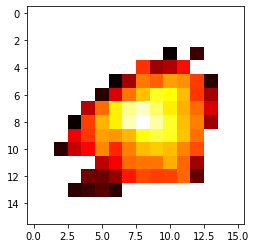

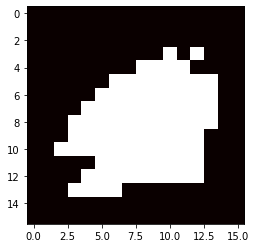

In [3]:
# Count frequency of each color bin

freq = [0] * (bins * bins)
for i in data_y.flatten():
    freq[i] += 1
print(sum([i > 0 for i in freq]))

log_freq = [[np.log10(freq[i*bins+j]) for j in range(bins)] for i in range(bins)]
plt.imshow(log_freq, cmap='hot', interpolation='nearest')
plt.show()

is_present = [[int(freq[i*bins+j] > 0) for j in range(bins)] for i in range(bins)]
plt.imshow(is_present, cmap='hot', interpolation='nearest')
plt.show()

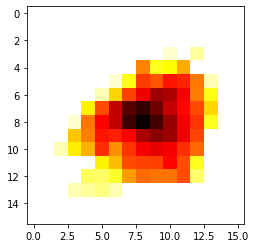

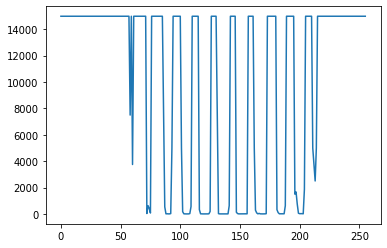

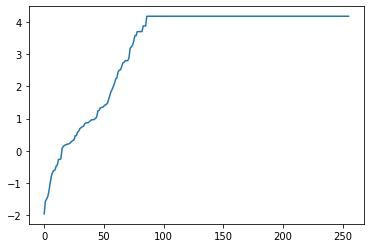

0.0109287985 14977.0


In [4]:
# Generate weights for color rebalancing later on
# TODO: Room for adjustment

weights = np.array(freq, dtype=np.float32) + 1
weights = (1 / weights) * (sum(weights) / len(weights))

# High flat line doesn't matter, those colors don't exist in true, weight won't be used
# weights = weights * 1e-1.   # Bit more uniform
# weights = weights           # Still lots of colors
# weights = weights * 1e1     # Lots of colors, keep on adjusting

weight_table = tf.lookup.StaticHashTable(
  tf.lookup.KeyValueTensorInitializer(range(len(weights)), weights, key_dtype=tf.int32, value_dtype=tf.float32), -1
)

log_weights = [[np.log10(weights[i*bins+j]) for j in range(bins)] for i in range(bins)]
plt.imshow(log_weights, cmap='hot', interpolation='nearest')
plt.show()

plt.plot(range(len(weights)), weights)
plt.show()

plt.plot(sorted(np.array(log_weights).flatten()))
plt.show()

print(min(weights), max(weights))

[4.41072649 4.41072649 4.41072649 4.41072649 4.41072648 4.41072614
 4.41072222 4.41070717 4.41069343 4.41070147 4.41070799 4.41070597
 4.4107114  4.41072082 4.41072549 4.41072634 4.41072649 4.41072649
 4.41072649 4.41072649 4.41072628 4.41071979 4.4106454  4.41035684
 4.41006428 4.4101285  4.41018267 4.41020916 4.4104336  4.41064321
 4.4107148  4.41072497 4.41072649 4.41072649 4.41072649 4.41072641
 4.41072194 4.41061139 4.40941694 4.40466062 4.39857094 4.39652437
 4.39604415 4.39854558 4.40475936 4.40921615 4.41053374 4.41070266
 4.41072649 4.41072646 4.41072535 4.41070349 4.41040936 4.40764438
 4.39088906 4.33728652 4.26023882 4.21057751 4.20883303 4.26504864
 4.34599387 4.3949388  4.40870996 4.41047133 4.41072645 4.41072504
 4.41068398 4.40995363 4.40135218 4.33758082 4.08705492 3.63360574
 3.25253956 3.13003173 3.2705759  3.63683952 4.07047094 4.32831198
 4.40023773 4.40936527 4.41072552 4.41070144 4.41008478 4.40024276
 4.29556615 3.70817144 2.59584001 1.82315141 1.54491947 1.6192

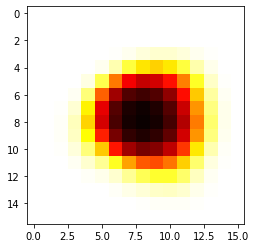

In [5]:
# Generate weights part 2 using RichZ technique

sigma = 1
lmda = 0.2

prob = [0] * (bins * bins)
for i in data_y.flatten():
    prob[i] += 1
prob = np.array(prob).astype(np.float32) / len(data_y.flatten())

prob = prob.reshape(bins, bins)
prob = cv2.GaussianBlur(prob, (0, 0), sigmaX=sigma)
prob = prob / np.sum(prob)
prob = prob.flatten()

weights = (1 - lmda) * prob + lmda / (bins * bins)
weights = 1 / weights

norm_factor = 1 / np.sum(prob * weights)
weights = weights * norm_factor
weights = weights ** 0.5

print(weights)
plt.imshow(weights.reshape(16, 16), cmap='hot', interpolation='nearest')
plt.show()

In [6]:
# Define the custom loss function used to account for inbalanced colors

def img_crossentropy(true_y, pred_y, weight_table, weights): # MY WEIGHTS ARE SCUFFED
    # True has shape (batch, rows, columns)
    # Pred has shape (batch, rows, columns, bins)
    H, W, bins = pred_y.shape[1:]

    loss = tf.one_hot(true_y, depth=bins, axis=-1) * tf.math.log(pred_y)
    loss = tf.reduce_sum(loss, axis=3)

    true_y_weights = tf.reshape(true_y, (-1,))
    true_y_weights = true_y_weights.numpy()
    true_y_weights = weights[true_y_weights]
    true_y_weights = tf.constant(true_y_weights, dtype=tf.float32)

    true_y_weights = tf.reshape(true_y_weights, (-1, H, W))
    loss = loss * true_y_weights

    loss = tf.reduce_sum(loss, axis=[1, 2])
    loss = loss / (-W*H)
    return loss

In [7]:
# Create the model with transfer learning and custom loss function

vgg = VGG16(weights="imagenet", include_top=False, input_shape=(300, 212, 3))
vgg.trainable = False
vgg = vgg.layers[:-1]

model = Sequential()
for l in vgg:
    model.add(l)

for i in range(2):
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_regularizer='l2', bias_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))

model.add(Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', kernel_regularizer='l2', bias_regularizer='l2'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.5))

model.add(Conv2DTranspose(bins * bins, (3, 3), strides=(2, 2), padding='same', kernel_regularizer='l2', bias_regularizer='l2'))
model.add(Softmax())

model.compile(optimizer="Adam", loss=(lambda t, p: img_crossentropy(t, p, None, weights)), metrics=["acc"], run_eagerly=True)
# model.compile(optimizer="Adam", loss=(lambda t, p: img_crossentropy(t, p, weight_table, np.array([1]*256, dtype=np.float32))), metrics=["acc"], run_eagerly=True)

58900480/58889256 [==============================] - 1s 0us/step


In [8]:
history = model.fit(x=train_x, y=train_y, batch_size=64, epochs=10, validation_split=0.1, verbose=1)

Epoch 1/10
13/13 [==============================] - 110s 6s/step - loss: 11.4165 - acc: 0.1017 - val_loss: 6.1100 - val_acc: 0.3027
Epoch 2/10
13/13 [==============================] - 46s 4s/step - loss: 3.3452 - acc: 0.2826 - val_loss: 3.5175 - val_acc: 0.3440
Epoch 3/10
13/13 [==============================] - 46s 4s/step - loss: 2.1076 - acc: 0.3345 - val_loss: 3.1488 - val_acc: 0.3588
Epoch 4/10
13/13 [==============================] - 47s 4s/step - loss: 1.9134 - acc: 0.3464 - val_loss: 2.9492 - val_acc: 0.3482
Epoch 5/10
13/13 [==============================] - 46s 4s/step - loss: 1.8354 - acc: 0.3514 - val_loss: 2.7392 - val_acc: 0.3567
Epoch 6/10
13/13 [==============================] - 46s 4s/step - loss: 1.8123 - acc: 0.3510 - val_loss: 2.7624 - val_acc: 0.3510
Epoch 7/10
13/13 [==============================] - 46s 4s/step - loss: 1.7975 - acc: 0.3556 - val_loss: 2.5741 - val_acc: 0.3552
Epoch 8/10
13/13 [==============================] - 47s 4s/step - loss: 1.7883 - acc: 0.

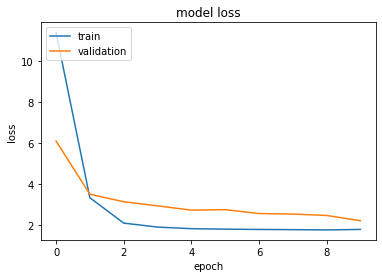

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
# Saving some output to look at manually

result_gray = test_x[:10]
result_gray = result_gray[:, :, :, 0].reshape(-1, 1, 300, 212) + 103.939
result_gray = result_gray.astype(np.uint8)

result_true = test_y[:10]
result_true = np.concatenate((result_true.reshape(-1, 1, 72, 52) // (256 // bins) * bins, result_true.reshape(-1, 1, 72, 52) % (256 // bins) * bins), axis=1)

result_predict = model.predict(test_x[:10])
result_predict = np.argmax(result_predict, axis=3).astype(np.uint8)
result_predict = np.concatenate((result_predict.reshape(-1, 1, 72, 52) // (256 // bins) * bins, result_predict.reshape(-1, 1, 72, 52) % (256 // bins) * bins), axis=1)

print(result_gray.shape, result_true.shape, result_predict.shape)
np.save(f'/content/drive/MyDrive/PetColorization/output/result_gray.npy', result_gray)
np.save(f'/content/drive/MyDrive/PetColorization/output/result_true.npy', result_true)
np.save(f'/content/drive/MyDrive/PetColorization/output/result_predict.npy', result_predict)

(10, 1, 300, 212) (10, 2, 72, 52) (10, 2, 72, 52)
